# PSP SPAN-Ion Velocity Distribution Function (VDF) Plotting Tutorial

Greetings! Below is a guide to plotting proton velocity-space distribution functions (VDFs) from the PSP SPAN-I instrument. If one is only interested in viewing a VDF at a particular time, the reader may skip to the last two cells.

We note that the SPAN-I instrument has many caveats and the data remains preliminary due to ongoing calibration work done by the instrument team. 

For optimal scientific interpretation of noteworthy event, the reader is strongly encouraged to contact a member of the instrument team:<br>
Roberto Livi rlivi@berkeley.edu <br>
Ali Rahmati rahmati@berkeley.edu <br>
Michael McManus mdmcmanus@berkeley.edu <br>
Davin Larson davin@berkeley.edu <br>

This tutorial was brought to you by: <br>
Jaye Verniero jaye.l.verniero@nasa.gov <br>
Kristoff Paulson kristoff.paulson@cfa.harvard.edu <br>
who may serve as points of contact for this tutorial. <br>

The paper describing the SPAN-I instrument in more detail can be found here: <br>https://doi.org/10.3847/1538-4357/ac93f5

This tutorial mirrors the SPAN-e plotting walkthrough found here: https://github.com/kpaulson/PSPGatewayHelp/blob/master/JupyterNotebook_Tutorials/PSP/SPANe_pitchAngleWalkthrough/PSP_SPANe_PitchAnglePlotter%20-%20PythonTutorial.ipynb
where the user can also learn about cdf files.

## Step 0

First, we import the cdf reader from cdflib (the library able to read the data encoded in the cdf format) and wget (which we will use here to grab and download the file from the remote server). We also import 'numpy' for math operations and 'datetime' for time unit conversions.

In [135]:
import cdflib
import numpy as np
from datetime import datetime
import os.path
import bisect
import matplotlib.pyplot as plt
import pyspedas 
import pandas as pd

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")


from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

## Step 1

Let's download the data! (Using pyspedas)

In [132]:


trange = ['2020-01-29/00:00','2020-01-30/00:00']
VDfile = pyspedas.psp.spi(trange, datatype = 'spi_sf00_8dx32ex8a', level = 'l2', notplot = True, time_clip = True, downloadonly = True, get_support_data = True)

21-Jul-25 22:48:53: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l2/spi_sf00_8dx32ex8a/2020/
21-Jul-25 22:48:53: File is current: psp_data/sweap/spi/l2/spi_sf00_8dx32ex8a/2020/psp_swp_spi_sf00_l2_8dx32ex8a_20200129_v04.cdf


Now, we open the cdf file and look at the variables along with their associated structure.

In [133]:
#open CDF file
dat = cdflib.CDF(VDfile[0]) 

#print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile=dat

#check variable formats in cdf file
print(cdf_VDfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


## Step 2
Let's define some variables!

In [134]:
epoch_ns        = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']

Type which timeslice you would like to plot in the format (year, month, day, hour, minute, second)

As of now, it is set up to input a single day, but future iterations of this tutorial will implement a time range. 

In [136]:
#convert time

datetime_t0 = datetime(2000, 1, 1, 12, 0, 0)
epoch_dt64 = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))
epoch = pd.to_datetime(epoch_dt64).to_pydatetime().tolist()

#epoch = pd.to_datetime(epoch_ns).to_pydatetime().tolist()

year = 2020
month = 1
day = 29
hour = 18
minute = 10
second = 2

timeSlice  = datetime(year, month, day, hour, minute, second)
print('Desired timeslice:',timeSlice)

#find index for desired timeslice
tSliceIndex  = bisect.bisect_left(epoch,timeSlice)
print('time Index:',tSliceIndex)
print('Time of closest data point:',epoch[tSliceIndex])

Desired timeslice: 2020-01-29 18:10:02
time Index: 9355
Time of closest data point: 2020-01-29 18:10:06.095190


Now define all variables at this time slice. 

In [137]:
epochSlice  = epoch[tSliceIndex]
thetaSlice  = theta[tSliceIndex,:]
phiSlice    = phi[tSliceIndex,:]
energySlice = energy[tSliceIndex,:]
efluxSlice  = eflux[tSliceIndex,:]

And now we rearrange to a more readable format reflecting 8 $\phi$-direction bins, 32 energy bins, and 8 $\theta$-direction bins. Note that the $\phi$ direction is most effected by partial obstruction by the heat shield, and therefore should be treated with extra caution (and ideally guidance from the instrument team).

In [138]:
thetaReshaped = thetaSlice.reshape((8,32,8))
phiReshaped = phiSlice.reshape((8,32,8))
energyReshaped = energySlice.reshape((8,32,8))
efluxReshaped = efluxSlice.reshape((8,32,8))

print(thetaReshaped.shape)

(8, 32, 8)


## Step 3
Now that we downloaded the data and defined the variables in the most optimal format, we are ready to begin our journey toward plotting a VDF.

In [139]:
mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

#Define VDF
numberFlux = efluxReshaped/energyReshaped
vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

#Convert to velocity units in each energy channel
vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

Next, rotate from energy-angle space to cartesian (vx,vy,vz) space (still in the SPAN-I instrument frame):

In [140]:
vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vz = vel *                                   np.sin(np.radians(thetaReshaped))

First, we plot the collapsed distribition function f(v), where all angles are summed as an approximation.

Text(0.5, 0, 'Velocity (km/s)')

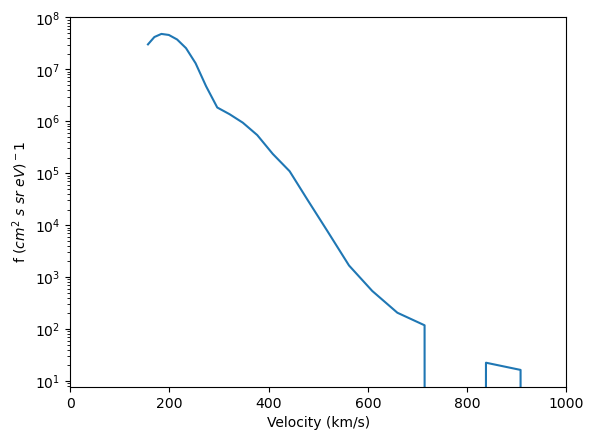

In [141]:
#sum over both phi and theta 
vdf_allAngles = np.sum(vdf, axis=(0,2))

#plot and set limits/labels
plt.plot(vel[0,:,0],vdf_allAngles)
plt.yscale('log')
plt.xlim(0,1000)
plt.ylabel(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')
plt.xlabel('Velocity (km/s)')


Now, instead of collapsing all angles, we can sum over individual axes.

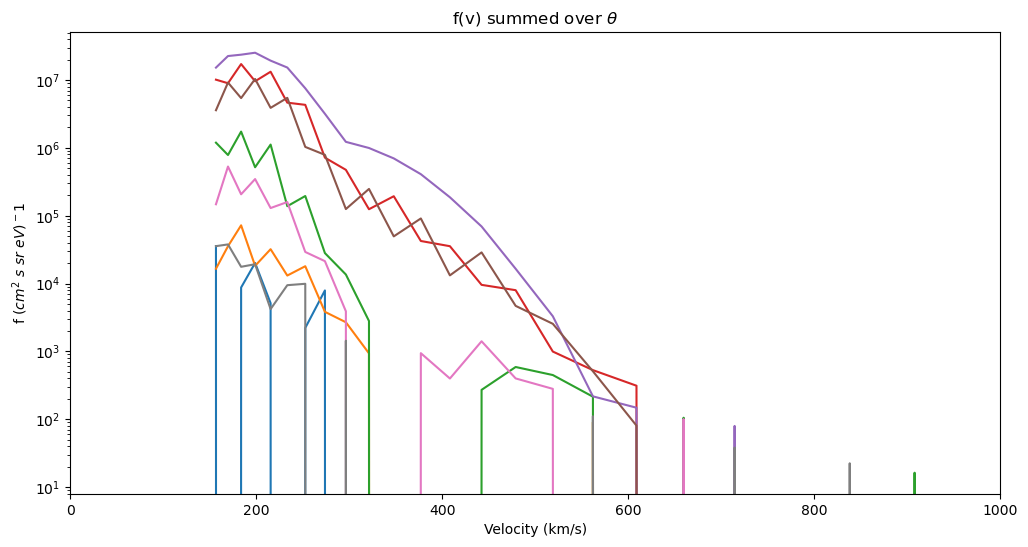

In [142]:
vdf_allThetas = np.sum(vdf, axis=0)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(vel[0,:,:],vdf_allThetas)

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\\theta$');


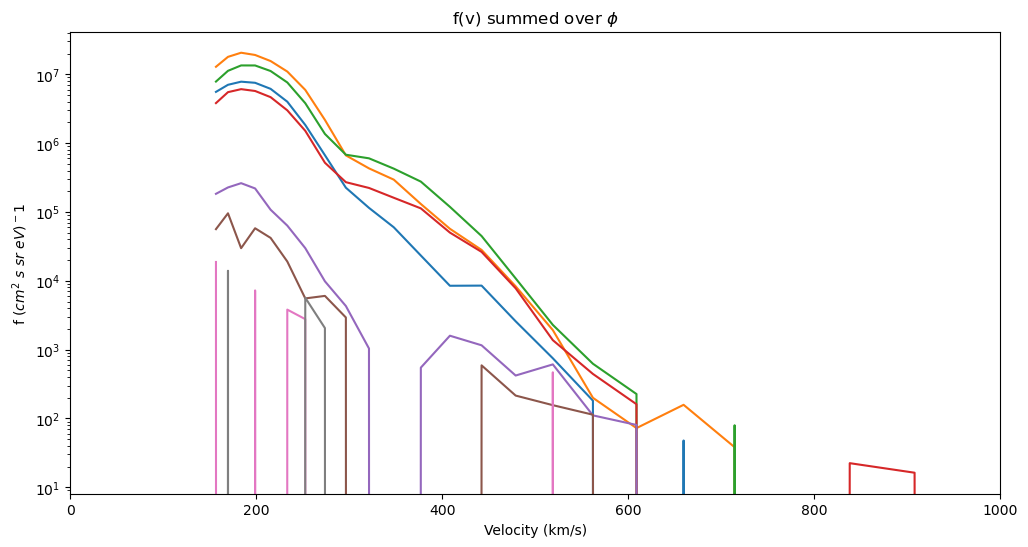

In [143]:
vdf_allPhis = np.sum(vdf, axis=2)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.transpose(vel[:,:,0]),np.transpose(vdf_allPhis))

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\phi$');


An alternative way to represent this data is to produce 2D contour plots through cuts in the $\theta$ and $\phi$ planes. This will reproduce the VDFs in the same formatting to the ones shown in Verniero et al. 2020 (DOI: 10.3847/1538-4365/ab86af)

Text(0.5, 1.0, 'VDF SPAN-I $\\theta$-plane')

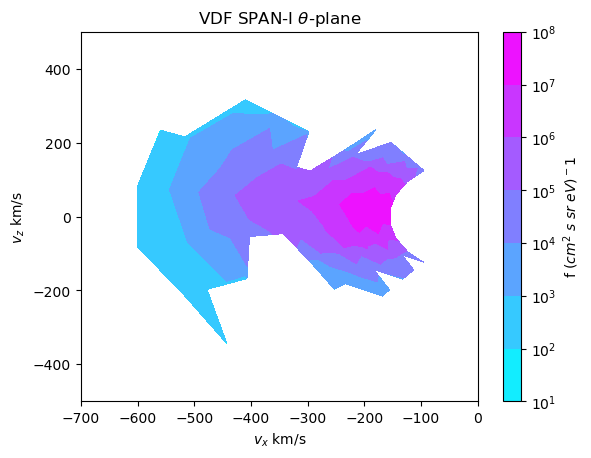

In [144]:
#theta is along dimension 0, while phi is along 2
#first cut through theta
theta_cut=0 

phi_plane = phiReshaped[theta_cut,:,:]
theta_plane = thetaReshaped[theta_cut,:,:]
energy_plane = energyReshaped[theta_cut,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_theta=np.nansum(vdf,axis=0)

vx_plane_theta = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_theta = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_theta = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane_theta, vz_plane_theta, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_z$ km/s')
ax.set_title('VDF SPAN-I $\\theta$-plane')

Note that this particular time slice is the ``hammerhead" distribution described in Verniero et al. 2022 (DOI: 10.3847/1538-4357/ac36d5)

Text(0.5, 1.0, 'VDF SPAN-I $\\phi$-plane')

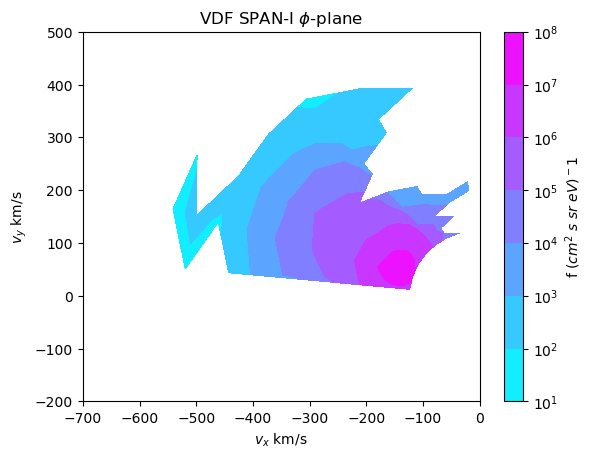

In [145]:
#now repeat for phi dimension
phi_cut = 1

phi_plane = phiReshaped[:,:,phi_cut]
theta_plane = thetaReshaped[:,:,phi_cut]
energy_plane = energyReshaped[:,:,phi_cut]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_phi=np.nansum(vdf,axis=2)

vx_plane_phi = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_phi = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_phi = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(np.transpose(vx_plane_phi), np.transpose(vy_plane_phi), np.transpose(df_phi),locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-200,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_y$ km/s')
ax.set_title('VDF SPAN-I $\\phi$-plane')

Notice that not all of the VDF is plotted. This is because the $\phi$ plane is most obstructed by the heat shield. One could use this visualization as a way to determine whether SPAN-I has sufficient field-of-view (FOV) for reliable measurements. One can see in this particular time slice, most of the "core" of the distribution is present, i.e. there exists a peak at the solar wind velocity around -150 km/s. 

# Magnetic Field-Aligned-Coordinates

This visualization of the VDF is in SPAN-I instrument coordinates. To extract more physical meaning, we can rotate to magnetic field-aligned coordinates (FAC) to plot the VDF in ($\mathbf{v}_\parallel$,$\mathbf{v}_\perp$) coordinate space. Here, the perpendcular and parallel directions are with respect to the mean magentic field direction, $\mathbf{B}_0$. Since the magnetic field data is at a much higher cadence than SPAN-I measures the plasma, we can define $\mathbf{B}_0$ as the magnetic field vector rotated into the SPAN-I instrument frame averaged over the 7s cadence of SPAN-I. For this step, we download the L3 SPAN-I data, which contains $\mathbf{B}_0$ in the SPAN-I instrument frame. In general, data analysis is more reliable when we perform computations in the SPAN-I instrument frame to mitigate FOV effects.

In [146]:
#Download L3 plasma moment data
MOMfile = pyspedas.psp.spi(trange, datatype = 'spi_sf00_l3_mom', level = 'l3', notplot = True, time_clip = True, downloadonly = True)


21-Jul-25 22:49:50: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2020/
21-Jul-25 22:49:50: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200129_v04.cdf


In [147]:
#open plasma moment CDF file
#print variable names in CDF files
MOMdat = cdflib.CDF(MOMfile[0])

print(MOMdat._get_varnames())
cdf_MOMfile=MOMdat
#check variable formats in cdf file
print(cdf_MOMfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'GAP', 'QUALITY_FLAG', 'DENS', 'VEL_INST', 'VEL_SC', 'VEL_RTN_SUN', 'T_TENSOR_INST', 'TEMP', 'EFLUX_VS_ENERGY', 'EFLUX_VS_THETA', 'EFLUX_VS_PHI', 'ENERGY_VALS', 'THETA_VALS', 'PHI_VALS', 'SUN_DIST', 'VENUS_DIST', 'SC_VEL_RTN_SUN', 'QUAT_SC_TO_RTN', 'MAGF_SC', 'MAGF_INST', 'ROTMAT_SC_INST'])


The following is a description of each variable: <br>
QUALITY FLAG - Data quality indicator <br>
DENS - Density (1/cm^3)<br>
VEL_INST - Velocity in SPAN-I instrument coordinates (km/s) <br>
VEL_SC - Spacecraft Velocity (km/s)<br>
VEL_RTN_SUN - Ion Velocity in RTN coordinates (km/s)<br>
TEMP - Ion Temperature (eV)<br>
T_TENSOR_INST - Temperature Tensor SPAN-I instrument coordinates <br>
EFLUX_VS_ENERGY - Proton Differential Energy Flux vs eV <br>
EFLUX_VS_THETA - Proton Differential Energy Flux vs Theta (deflectors)<br>
EFLUX_VS_PHI - Proton Differential Energy Flux vs Phi (anodes)<br>
SUN-DIST - Distance from Sun (km)<br>
VENUS-DIST - Distance from Venus (km)
SC_VEL_RTN- Spacecraft Velocity in RTN coordinates (km/s)<br>
QUAT_SC_TO_RTN - Quaternion rotation of spacecraft in RTN coordinates<br>
MAGF_SC - Magnetic field downsampled to SPAN_I time resolution in spacecraft coordinates (nT)<br>
MAGF_INST - Magnetic field downsampled to SPAN_I time resolution in SPAN-I instrument coordinates (nT)<br>

Specific details on these variables will be left for a future tutorial. An existing one to get started using PySPEDAS is located in this directory.
For now, we are interested in only the MAGF-INST variable.

In [148]:
#Define variables

epoch_nsMOM = cdf_MOMfile['Epoch']
B_SPAN = cdf_MOMfile['MAGF_INST']

B_SPANslice = B_SPAN[tSliceIndex,:]

if B_SPANslice.ndim == 2:
    Bx_SPAN = B_SPANslice[:,0]
    By_SPAN = B_SPANslice[:,1]
    Bz_SPAN = B_SPANslice[:,2]
elif B_SPANslice.ndim == 1:
    Bx_SPAN = B_SPANslice[0]
    By_SPAN = B_SPANslice[1]
    Bz_SPAN = B_SPANslice[2]

Now that we have the magnetic field direction in the SPANi instrument coordinates, we can rotate the processed data into field-aligned coordinates. We will define two processes here below, one of which will output the elements of a rotation matrix from instrument to field-aligned coordinates (made up of the three unit vectors defining those coordinates), and another which will rotate an input vector from instrument to field-aligned coordinates.

This process will make several assumptions, the largest being that the magnetic field is perfectly defined by each measurement over the course of the SPANi collection period. 

(Future Work: The field measurment can be defined at each anode measurement time for each sub-frame of SPANi data, but we would have to use the merged FGM-SCM data product and better pinpoint the timestamps on each submeasurement of the instrument.)

In [149]:
def fieldAlignedCoordinates(Bx, By, Bz):
    '''
    INPUTS:
         Bx, By, Bz = rank1 arrays of magnetic field measurements in instrument frame
    '''
    import numpy as np


    Bmag = np.sqrt(Bx**2 + By**2 + Bz**2)

    # Define field-aligned vector
    Nx = Bx/Bmag
    Ny = By/Bmag
    Nz = Bz/Bmag

    # Make up some unit vector
    if np.isscalar(Nx):
        Rx = 0
        Ry = 1.
        Rz = 0
    else:
        Rx = np.zeros(Nx.len())
        Ry = np.ones(len(Nx))
        Rz = np.zeros(len(Nx))

    # Find some vector perpendicular to field NxR 
    TEMP_Px = ( Ny * Rz ) - ( Nz * Ry )  # P = NxR
    TEMP_Py = ( Nz * Rx ) - ( Nx * Rz )  # This is temporary in case we choose a vector R that is not unitary
    TEMP_Pz = ( Nx * Ry ) - ( Ny * Rx )


    Pmag = np.sqrt( TEMP_Px**2 + TEMP_Py**2 + TEMP_Pz**2 ) #Have to normalize, since previous definition does not imply unitarity, just orthogonality
  
    Px = TEMP_Px / Pmag # for R=(0,1,0), NxR = P ~= RTN_N
    Py = TEMP_Py / Pmag
    Pz = TEMP_Pz / Pmag


    Qx = ( Pz * Ny ) - ( Py * Nz )   # N x P
    Qy = ( Px * Nz ) - ( Pz * Nx )  
    Qz = ( Py * Nx ) - ( Px * Ny )  

    return(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)


# ###
# ### TRANSFORM VECTOR DATA INTO FIELD-ALIGNED COORDINATES
# ###

def rotateVectorIntoFieldAligned(Ax, Ay, Az, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz):
    # For some Vector A in the SAME COORDINATE SYSTEM AS THE ORIGINAL B-FIELD VECTOR:

    An = (Ax * Nx) + (Ay * Ny) + (Az * Nz)  # A dot N = A_parallel
    Ap = (Ax * Px) + (Ay * Py) + (Az * Pz)  # A dot P = A_perp (~RTN_N (+/- depending on B), perpendicular to s/c y)
    Aq = (Ax * Qx) + (Ay * Qy) + (Az * Qz)  # 

    return(An, Ap, Aq)


Now we will run the data selected earlier in the tutorial through the rotation subprocesses

(32, 8)
(32, 8)


Text(0.5, 1.0, 'VDF SPAN-I instrument coordinates')

21-Jul-25 22:50:02: Substituting symbol \perp from STIXGeneral
21-Jul-25 22:50:02: Substituting symbol \perp from STIXGeneral
21-Jul-25 22:50:02: Substituting symbol \perp from STIXGeneral
21-Jul-25 22:50:02: Substituting symbol \perp from STIXGeneral
21-Jul-25 22:50:03: Substituting symbol \perp from STIXGeneral
21-Jul-25 22:50:03: Substituting symbol \perp from STIXGeneral


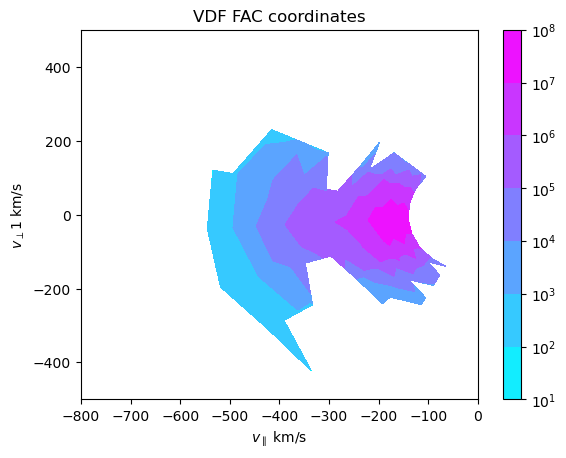

21-Jul-25 22:50:03: Substituting symbol \perp from STIXGeneral
21-Jul-25 22:50:03: Substituting symbol \perp from STIXGeneral


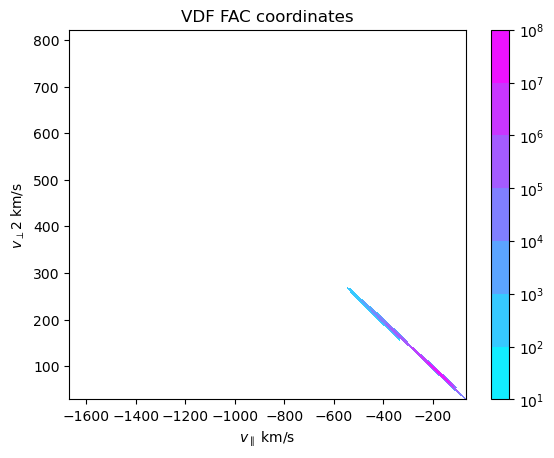

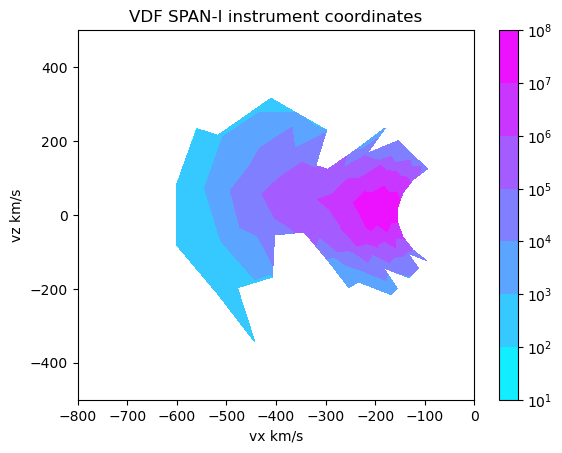

In [150]:
(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz) = fieldAlignedCoordinates(Bx_SPAN, By_SPAN, Bz_SPAN)

(vn_plane, vp_plane, vq_plane) = rotateVectorIntoFieldAligned(vx_plane_theta, vy_plane_theta, vz_plane_theta, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)


print(vn_plane.shape)
print(vp_plane.shape)

fig,ax=plt.subplots()
cs=ax.contourf(vn_plane, vp_plane, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_\parallel$ km/s')
ax.set_ylabel('$v_\perp1$ km/s')
ax.set_title('VDF FAC coordinates')

fig,ax=plt.subplots()
cs=ax.contourf(vn_plane, vq_plane, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
#ax.set_xlim(-800,0)
#ax.set_ylim(-500,500)
ax.set_xlabel('$v_\parallel$ km/s')
ax.set_ylabel('$v_\perp2$ km/s')
ax.set_title('VDF FAC coordinates')

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane_theta, vz_plane_theta, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)
ax.set_xlabel('vx km/s')
ax.set_ylabel('vz km/s')
ax.set_title('VDF SPAN-I instrument coordinates')


Now we can put it all together into a single plotting script where all we input is the timestamp:

In [189]:
def spp_swp_spi_VDF_plot(timeslice):

    ############################
    ############################
    ##### PACKAGES #############
    ############################
    ############################
    
    import cdflib
    import numpy as np
    from datetime import datetime
    import os.path
    import bisect
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    from matplotlib import ticker, cm
    import warnings 
    warnings.filterwarnings("ignore")

    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)
    #import datetime
    import pandas as pd 

    ############################
    ############################
    ##### DOWNLOAD #############
    ############################
    ############################
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day

    trange = [str(year) + '-' + str(month) + '-' + str(day) + '/00:00', str(year) + '-' + str(month) + '-' + str(day) + '/23:59']
    VDfile = pyspedas.psp.spi(trange, datatype = 'spi_sf00_8dx32ex8a', level = 'l2', notplot = True, time_clip = True, downloadonly = True)
          
    cdf_VDfile = cdflib.CDF(VDfile[0])

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']
    
    ############################
    ############################
    ##### TIMESLICER ###########
    ############################
    ############################
    datetime_t0 = datetime(2000, 1, 1, 12, 0, 0)
    epoch_dt64 = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))
    epoch = pd.to_datetime(epoch_dt64).to_pydatetime().tolist()

    print('Desired timeslice:',timeslice)
    tSliceIndex  = bisect.bisect_left(epoch, timeslice)
    print('time Index:',tSliceIndex)
    print('Time of closest data point:',epoch[tSliceIndex])

    epochSlice  = epoch[tSliceIndex]
    thetaSlice  = theta[tSliceIndex,:]
    phiSlice    = phi[tSliceIndex,:]
    energySlice = energy[tSliceIndex,:]
    efluxSlice  = eflux[tSliceIndex,:]

    ############################
    ############################
    ##### REFORMAT #############
    ############################
    ############################

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))

    ############################
    ############################
    ##### PLOT #################
    ############################
    ############################
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    plt.rcParams.update({
                         'font.size': 20,
                         'axes.titlesize': 16
                        })

    fig = plt.figure(figsize=(18, 6))
    #using gridspec for layout
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.4)

    ax1 = fig.add_subplot(gs[0])  # 1D line plot
    ax2 = fig.add_subplot(gs[1])  # θ-plane
    ax3 = fig.add_subplot(gs[2])  # φ-plane
    cax = fig.add_subplot(gs[3])  # colorbar


    ############################
    ##### 1D Collapsed PLOT ####
    ############################
    #sum over both phi and theta 
    vdf_allAngles = np.sum(vdf, axis=(0,2))

    #plot and set limits/labels
    ax1.plot(vel[0,:,0],vdf_allAngles)
    ax1.set_yscale('log')
    ax1.set_xlim(0,1000)
    ax1.set_ylabel(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')
    ax1.set_xlabel('Velocity (km/s)')

    thetaplot_cut = 0
    phiplot_cut = 2

    ############################
    ##### THETA PLANE PLOT #####
    ############################
    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df_theta=np.nansum(vdf,axis=thetaplot_cut)

    vx_plane_theta = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane_theta = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane_theta = vel_plane *                                   np.sin(np.radians(theta_plane))

    cs2=ax2.contourf(vx_plane_theta, vz_plane_theta, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
    #uncomment if want second colorbar, but should be same as other one
    #cbar2 = fig.colorbar(cs2, ax = ax2)
    #cbar2.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

    ax2.set_xlim(-800,0)
    ax2.set_ylim(-400,400)
    ax2.set_xlabel('$v_x$ km/s')
    ax2.set_ylabel('$v_z$ km/s', labelpad=-20)
    ax2.set_title('$\\theta$-plane')

    #ax2.set_title('VDF SPAN-I $\\theta$-plane '+epoch[tSliceIndex].isoformat(timespec='seconds'))

    ############################
    ##### PHI PLANE PLOT #######
    ############################
    #now repeat for phi dimension
    phi_cut = 1

    phi_plane = phiReshaped[:,:,1]
    theta_plane = thetaReshaped[:,:,1]
    energy_plane = energyReshaped[:,:,1]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df_phi=np.nansum(vdf,axis=phiplot_cut)

    vx_plane_phi = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane_phi = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane_phi = vel_plane *                                   np.sin(np.radians(theta_plane))

    cs3=ax3.contourf(np.transpose(vx_plane_phi), np.transpose(vy_plane_phi), np.transpose(df_phi),locator=ticker.LogLocator(),cmap=cm.cool)
    #cbar3 = fig.colorbar(cs3, ax = ax3)
    #cbar3.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

    ax3.set_xlim(-800,0)
    ax3.set_ylim(-200,600)
    ax3.set_xlabel('$v_x$ km/s')
    ax3.set_ylabel('$v_y$ km/s', labelpad=-20)
    ax3.set_title('$\\phi$-plane')

    # ---- Shared Colorbar ----
    cbar = fig.colorbar(cs2, cax=cax)
    cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')


    fig.subplots_adjust(wspace=0.4)  # adjust this value to your liking
    ax2.set_aspect('equal', adjustable='box')
    ax3.set_aspect('equal', adjustable='box')

    fig.suptitle('VDF SPAN-I '+epoch[tSliceIndex].isoformat(timespec='seconds'))



21-Jul-25 23:10:55: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l2/spi_sf00_8dx32ex8a/2020/
21-Jul-25 23:10:55: File is current: psp_data/sweap/spi/l2/spi_sf00_8dx32ex8a/2020/psp_swp_spi_sf00_l2_8dx32ex8a_20200129_v04.cdf


Desired timeslice: 2020-01-29 18:10:02
time Index: 9355
Time of closest data point: 2020-01-29 18:10:06.095190


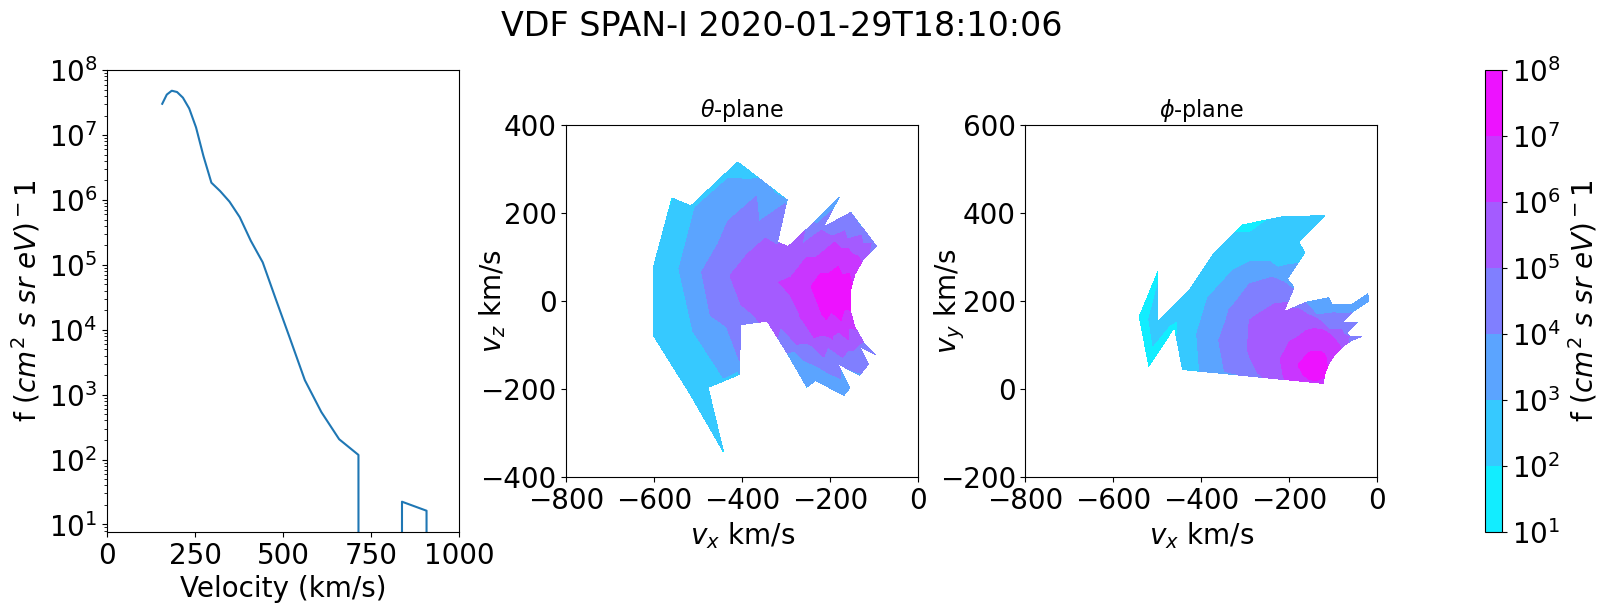

In [190]:


# datetime(YYYY, mm, dd, HH, MM)
timeSlice  = datetime(2020, 1, 29, 18, 10, 2)   # Original test slice  

spp_swp_spi_VDF_plot(timeSlice)
